In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

### Import data

In [2]:
df_Ch001 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/data/Ch022.pkl"))

### Split data

In [3]:
import torch
from sklearn.model_selection import train_test_split

In [4]:
p=19

split_data=int(len(df_Ch022.index)*0.9)

data_1=df_Ch001.iloc[:split_data,p].values
data_2=df_Ch009.iloc[:split_data,p].values
data_3=df_Ch020.iloc[:split_data,p].values

data=np.vstack((data_1, data_2, data_3)).T
target=df_Ch022.iloc[1:,p]
target=target.iloc[:split_data].values[:,np.newaxis]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=30)
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

In [6]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [7]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=3398)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=850)

### ANN model

In [8]:
class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(3, 40)
        self.fc2 = nn.Linear(40,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating Model, Optimizer and Loss

In [9]:
# creating model,and defining optimizer and loss
model = ReLUNet()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [10]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [11]:
# defining the number of epochs
epochs = 1000
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [12]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [13]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [14]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [15]:
checkpointer = ModelCheckpoint('./saved_models', 'ANN_nonscale', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {str(p): model})

### Run Engine

In [16]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch: 1  Avg loss: 30.65
Validation Results - Epoch: 1  Avg loss: 31.83
Training Results - Epoch: 2  Avg loss: 29.07
Validation Results - Epoch: 2  Avg loss: 30.22
Training Results - Epoch: 3  Avg loss: 27.59
Validation Results - Epoch: 3  Avg loss: 28.71
Training Results - Epoch: 4  Avg loss: 26.21
Validation Results - Epoch: 4  Avg loss: 27.29
Training Results - Epoch: 5  Avg loss: 24.93
Validation Results - Epoch: 5  Avg loss: 25.98
Training Results - Epoch: 6  Avg loss: 23.77
Validation Results - Epoch: 6  Avg loss: 24.80
Training Results - Epoch: 7  Avg loss: 22.76
Validation Results - Epoch: 7  Avg loss: 23.77
Training Results - Epoch: 8  Avg loss: 21.90
Validation Results - Epoch: 8  Avg loss: 22.90
Training Results - Epoch: 9  Avg loss: 21.18
Validation Results - Epoch: 9  Avg loss: 22.20
Training Results - Epoch: 10  Avg loss: 20.59
Validation Results - Epoch: 10  Avg loss: 21.61
Training Results - Epoch: 11  Avg loss: 20.09
Validation Results - Epoch: 11  

State:
	iteration: 376
	epoch: 188
	epoch_length: 2
	max_epochs: 1000
	output: 0.000258916086750105
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

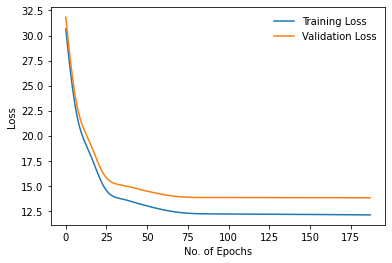

In [17]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [25]:
p=19
model.load_state_dict(torch.load(Path("C:/Users/Victor/Desktop/PIR/model/saved_models/ANN_nonscale_19_376.pt")))
print("Model Loaded")

Model Loaded


In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
model.to("cpu")

data_1_test=df_Ch001.iloc[:,p].values
data_2_test=df_Ch009.iloc[:,p].values
data_3_test=df_Ch020.iloc[:,p].values

data_test=np.vstack((data_1_test, data_2_test, data_3_test)).T
data_test=torch.tensor(data_test).float()
y_test=df_Ch022.iloc[1:, p].values

y_pred_test=model(data_test).detach().numpy()
MSE=mean_squared_error(y_test, y_pred_test)
print(MSE)


11.775398769397567


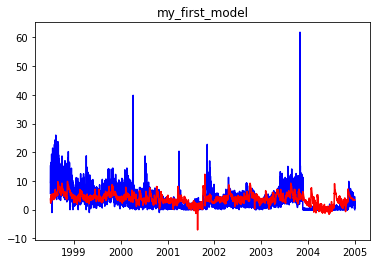

In [28]:
    plt.figure()
    plt.plot(df_Ch022.index[1:], y_test, color= "blue")
    plt.plot(df_Ch022.index[1:], y_pred_test, color="red")
    plt.title("my_first_model")

    plt.show()

In [22]:
test123=df_Ch022.iloc[:, p].copy()
print(test123)

1998.496576    2.381
1998.497946    1.446
1998.499316    2.386
1998.500686    1.399
1998.502056    1.914
               ...  
2004.994956    5.303
2004.996326    9.790
2004.997696    7.359
2004.999066    6.656
2004.999875    2.273
Name: 3.015005, Length: 4722, dtype: float64


In [23]:
# from sklearn.preprocessing import StandardScaler
# df_12=pd.read_pickle(Path('C:/Users/Victor/Desktop/PIR/process/Ch022.pkl'))
# df_123=pd.read_pickle(Path('C:/Users/Victor/Desktop/PIR/data/Ch022.pkl'))
# df_123 = df_123[df_123.index > df_123.index[0]].copy()
# df_123.plot(y=df_123.columns[p])
# df_123[df_123 <= 0] = 0.01
# df_123 = df_123.apply(lambda x: np.log(x))
# scaler= StandardScaler()
# df_123[:]=scaler.fit_transform(df_123.values)
# y_pred_test=model(data_test).detach().numpy()
# df_123.iloc[:,p] = y_pred_test
# df_123[:]=scaler.inverse_transform(df_123.values)
# plt.plot(df_123.index, df_123.iloc[:,p].apply(lambda x: np.exp(x)))


In [24]:
df_12.plot(y=df_123.columns[24])


NameError: name 'df_12' is not defined

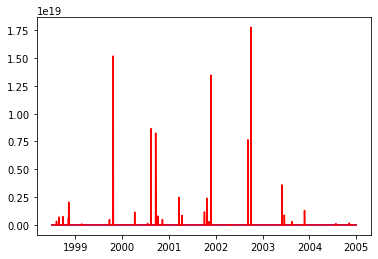

In [125]:
df_124=pd.read_pickle(Path('C:/Users/Victor/Desktop/PIR/data/Ch022.pkl'))

df_124=df_124.iloc[1:,24].copy()
np_df_124=df_124.values.reshape(-1,1)
scaler2= StandardScaler()
scaler2.fit(np_df_124)

y_pred_test=model(data_test).detach().numpy()
y_pred_test=scaler2.inverse_transform(y_pred_test)
y_pred_test=np.exp(y_pred_test)

plt.figure()
plt.plot(df_124.index, df_124.values, color="blue")
plt.plot(df_124.index, y_pred_test, color="red")
plt.show()